# Single Molecule Fluorescence Photobleaching Data Analyses—Step Finding Algorithm

In [8]:
pip install tqdm

In [9]:
import pickle
import numpy as np
import pandas as pd
import ruptures as rpt
from itertools import product
from collections import Counter
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

from matplotlib.backends.backend_pdf import PdfPages as pltPdf

In [2]:
os.getcwd()

'User_Dir'

### Import Sample Data

In [3]:
fname = 'D:\\Desktop\\Working Folder\\Parul\\NewProgram\\virus1.txt'
signal = pd.read_csv(fname)
signal.columns = ['ts', 'val']
signal.head()

,ts,val
0,0.00000,24758.55
1,0.06006,24642.00
2,0.12012,28205.10
3,0.18018,26823.15
4,0.24024,24059.25


In [4]:
handle = fname.split("\\")[-1]
handle = handle.split(".")[0]
handle

'virus1'

# fname = fname
handle = fname.split(".")[0]
signal = pd.read_csv(fname)
signal.columns = ['ts', 'val']
signal.head()

In [5]:
signal.tail()

,ts,val
995,59.75976,2231.10
996,59.81982,1781.55
997,59.87988,2164.50
998,59.93994,1648.35
999,60.00000,2131.20


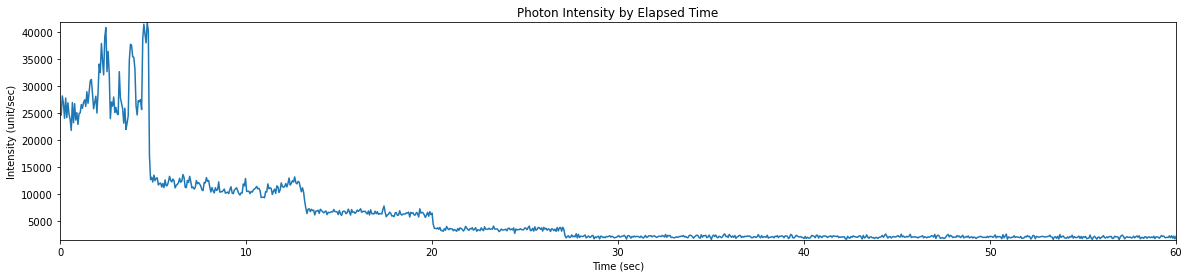

In [6]:
# inspect input signal
plt.rcParams["figure.figsize"] = (20,4)
plt.plot(signal.ts, signal.val, label='Signal')
plt.title('Photon Intensity by Elapsed Time')
plt.xlabel('Time (sec)')
plt.ylabel('Intensity (unit/sec)')
plt.margins(0)

plt.savefig('{}_input_signal.svg'.format(handle), format='svg', dpi=1600)

plt.show()
plt.close()

#### Observations

A major inflection point is seen at about 10 secs. Changepoint detection leaving out the rest of the data makes sense.

## Select most frequent Changepoints from all the methods and models

Using entire signal length

In [12]:
%%time

plt.rcParams["figure.figsize"] = (20,4)
plt.ioff()  # interactive mode off, use plt.show() to force inline display of plots

MAX_BREAKPOINTS = 15
BREAKPOINTS = range(4, MAX_BREAKPOINTS+1)

# input signal
X = signal.val.values

# container for experiment results
res_ls = list()

# container for all valid change points (for freq analysis)
cps_ls = list()

### WINDOW METHOD
method = "Window"

# training parameters
MODELS = ["rbf", "l1",]
WINDOW_SIZES = [8, 10, 12, 15, 18, 20, 22, 25]

# container for multi-page pdf plot
pdfFig = pltPdf("{}_cps_plots_{}.pdf".format(handle, method))

# train detector
for (m, w, b) in tqdm(product(MODELS, WINDOW_SIZES, BREAKPOINTS)):
    cps = rpt.Window(width=w, min_size=2, jump=1).fit_predict(X, n_bkps=b)
    # store changepoints
    cps_ls.extend(cps[:-1])
    # plot changepoints
    fig, ax = rpt.display(X, cps)
    fig.suptitle("Method: {}, Model: {}, BreakPoints: {}".format(method, m, b))
    pdfFig.savefig(fig)
    plt.close(fig)

pdfFig.close()

### PELT METHOD
method = "Pelt"

# training parameters
MODELS = ["rbf", ]
PENALTIES = np.linspace(0.25, 2.5, 20)

# container for multi-page pdf plot
pdfFig = pltPdf("{}_cps_plots_{}.pdf".format(handle, method))

# train detector
for (m, p) in tqdm(product(MODELS, PENALTIES)):
    cps = rpt.Pelt(model=m, min_size=2, jump=1).fit_predict(X, pen=p)
    # store changepoints
    cps_ls.extend(cps[:-1])
    # plot changepoints
    fig, ax = rpt.display(X, cps)
    fig.suptitle("Method: {}, Model: {}, Penalty: {}".format(method, m, p))
    pdfFig.savefig(fig)
    plt.close(fig)

pdfFig.close()

### OTHER METHODS
METHODS = ["Binseg", "BottomUp", "Dynp"]

# training parameters
MODELS = ["rbf", "l1"]

for method in tqdm(METHODS):
    # container for multi-page pdf plot
    pdfFig = pltPdf("{}_cps_plots_{}.pdf".format(handle, method))
    
    # train detector
    for (m, b) in product(MODELS, BREAKPOINTS):
        if method == "Binseg":
            cps = rpt.Binseg(model=m, min_size=2, jump=1).fit_predict(X, n_bkps=b)
        if method == "BottomUp":
            cps = rpt.BottomUp(model=m, min_size=2, jump=1).fit_predict(X, n_bkps=b)
        if method == "Dynp":
            cps = rpt.Dynp(model=m, min_size=2, jump=1).fit_predict(X, n_bkps=b)            
        # store changepoints
        cps_ls.extend(cps[:-1])            
        # plot changepoints
        fig, ax = rpt.display(X, cps)
        fig.suptitle("Method: {}, Model: {}, BreakPoints: {}".format(method, m, b))
        pdfFig.savefig(fig)
        plt.close(fig)
    pdfFig.close()
    
cps_fq = Counter(cps_ls)  # produces dict ordered by counts of cp occurances

"""
# archive changepoints, and their count by occurance
with open("cps_list.pkl", "wb") as f:
    pickle.dump(cps, f)
with open("cps_freq.pkl", "wb") as f:
    pickle.dump(cps_fq, f)
"""

192it [00:31,  6.03it/s]
20it [02:37,  7.88s/it]
100%|██████████| 3/3 [27:45<00:00, 555.25s/it]

CPU times: total: 30min 25s
Wall time: 30min 55s


'\n# archive changepoints, and their count by occurance\nwith open("cps_list.pkl", "wb") as f:\n    pickle.dump(cps, f)\nwith open("cps_freq.pkl", "wb") as f:\n    pickle.dump(cps_fq, f)\n'

In [13]:
print(cps_fq)

Counter({219: 234, 62: 227, 80: 221, 334: 210, 452: 206, 45: 197, 35: 119, 134: 111, 19: 92, 74: 86, 135: 68, 118: 66, 68: 63, 81: 63, 44: 58, 24: 54, 198: 48, 21: 40, 292: 38, 335: 36, 164: 34, 8: 32, 220: 29, 36: 24, 186: 22, 180: 21, 34: 21, 22: 20, 277: 20, 179: 18, 57: 18, 6: 16, 202: 16, 176: 16, 75: 15, 9: 14, 137: 14, 27: 14, 221: 14, 67: 14, 185: 12, 392: 12, 175: 12, 29: 12, 274: 11, 174: 10, 735: 10, 673: 10, 204: 9, 40: 9, 46: 9, 42: 8, 97: 7, 117: 6, 291: 6, 391: 6, 88: 5, 216: 5, 107: 4, 205: 4, 275: 4, 261: 4, 697: 4, 2: 4, 4: 4, 53: 4, 55: 4, 65: 3, 82: 3, 184: 3, 106: 2, 734: 2, 848: 2, 11: 2, 14: 2, 49: 2, 129: 2, 167: 2, 215: 2, 37: 1, 70: 1, 78: 1, 30: 1, 279: 1})


In [14]:
MAX_BREAKPOINTS = 15
top_n = dict(cps_fq.most_common(MAX_BREAKPOINTS))
top_n = sorted(list(top_n.keys())) + [len(signal.ts)]
scale = max(cps_fq.values())
top_n, scale

([19, 35, 44, 45, 62, 68, 74, 80, 81, 118, 134, 135, 219, 334, 452, 1000], 234)

In [15]:
%%time

top_n = dict(cps_fq.most_common(MAX_BREAKPOINTS))

top_n = sorted(list(top_n.keys())) + [len(signal.ts)-2]

scale = max(cps_fq.values())

results_ls = list()

prev = 0

for ix in top_n:
    results_ls.append([ix, signal.ts[ix],
                       signal.val[ix-1], signal.val[ix], signal.val[ix+1], 
                       cps_fq[ix]/scale, np.mean(signal.val[prev:ix])])
    prev = ix

results_df = pd.DataFrame(results_ls, columns=["Id", "Timestamp", "Prev Signal Value",
                                               "Changepoint Value", "Next Signal Value",
                                               "Changepoint Significance", "Average Signal Over Window"
                                              ])
results_df

CPU times: total: 0 ns
Wall time: 4.13 ms


,Id,Timestamp,Prev Signal Value,Changepoint Value,Next Signal Value,Changepoint Significance,Average Signal Over Window
0,19,1.141141,25041.60,26606.70,25907.40,0.393162,25081.910526
1,35,2.102102,28837.80,34132.50,32534.10,0.508547,27734.737500
2,44,2.642643,36480.15,32400.90,23992.65,0.247863,35638.400000
3,45,2.702703,32400.90,23992.65,27072.90,0.841880,32400.900000
4,62,3.723724,24508.80,34881.75,37795.50,0.970085,25783.994118
5,68,4.084084,33216.75,26390.25,24675.30,0.269231,35728.125000
6,74,4.444444,25674.30,38811.15,41541.75,0.367521,26454.075000
7,80,4.804805,40293.00,17199.45,12670.65,0.944444,40046.025000
8,81,4.864865,17199.45,12670.65,13086.90,0.269231,17199.450000
9,118,7.087087,12287.70,11122.20,11272.05,0.282051,12283.200000


In [16]:
results_df.to_csv("{}_final_changepoints.csv".format(handle))

### Plot Changepoints

In [17]:
%%time

pdfFig = pltPdf("{}_final_signal_with_cps_plots.pdf".format(handle))

for n in BREAKPOINTS:
    # select top N changepoints from the ordered Dict
    top_n = dict(cps_fq.most_common(n))
    print(n, top_n)
    
    # plot parameters
    plt.rcParams["figure.figsize"] = (30, 4)
    plt.title('Significant {} Change-Points: Photon Intensity by Elapsed Time'.format(n))
    plt.xlabel('Time (sec)')
    plt.ylabel('Intensity (unit/sec)')
    plt.margins(0)

    # plot the original signal
    plt.plot(signal.ts, signal.val, label='Signal')
    
    # overlay averaged signal values
    overlay = list()
    prev = 0
    for ix in sorted(list(top_n.keys())):
        plt.axvline(x=signal.ts[ix], color='g')  # plot changepoints
        overlay.extend([np.mean(signal.val[prev:ix])]*(ix-prev))
        prev = ix
    overlay.extend([np.mean(signal.val[ix:])]*(len(signal.val)-ix))
    
    # plot overlay values
    plt.plot(signal.ts, overlay, color='k', label='Averaged Signal')

    # save plot
    #plt.savefig('signal_with_{}_cps.svg'.format(n), format='svg', dpi=1600)
    
    pdfFig.savefig()
    plt.close()

pdfFig.close()

4 {219: 234, 62: 227, 80: 221, 334: 210}
5 {219: 234, 62: 227, 80: 221, 334: 210, 452: 206}
6 {219: 234, 62: 227, 80: 221, 334: 210, 452: 206, 45: 197}
7 {219: 234, 62: 227, 80: 221, 334: 210, 452: 206, 45: 197, 35: 119}
8 {219: 234, 62: 227, 80: 221, 334: 210, 452: 206, 45: 197, 35: 119, 134: 111}
9 {219: 234, 62: 227, 80: 221, 334: 210, 452: 206, 45: 197, 35: 119, 134: 111, 19: 92}
10 {219: 234, 62: 227, 80: 221, 334: 210, 452: 206, 45: 197, 35: 119, 134: 111, 19: 92, 74: 86}
11 {219: 234, 62: 227, 80: 221, 334: 210, 452: 206, 45: 197, 35: 119, 134: 111, 19: 92, 74: 86, 135: 68}
12 {219: 234, 62: 227, 80: 221, 334: 210, 452: 206, 45: 197, 35: 119, 134: 111, 19: 92, 74: 86, 135: 68, 118: 66}
13 {219: 234, 62: 227, 80: 221, 334: 210, 452: 206, 45: 197, 35: 119, 134: 111, 19: 92, 74: 86, 135: 68, 118: 66, 68: 63}
14 {219: 234, 62: 227, 80: 221, 334: 210, 452: 206, 45: 197, 35: 119, 134: 111, 19: 92, 74: 86, 135: 68, 118: 66, 68: 63, 81: 63}
15 {219: 234, 62: 227, 80: 221, 334: 210, 452:

### PROCESSING COMPLETE

In [46]:
pip install ruptures

Note: you may need to restart the kernel to use updated packages.


In [47]:
cps_fq.most_common(1)

[(219, 137)]

In [48]:
results_df

,Id,Timestamp,Prev Signal Value,Changepoint Value,Next Signal Value,Changepoint Significance,Average Signal Over Window
0,35,2.102102,28837.80,34132.50,32534.10,0.503650,26294.631429
1,45,2.702703,32400.90,23992.65,27072.90,0.854015,35314.650000
2,62,3.723724,24508.80,34881.75,37795.50,0.927007,25783.994118
3,74,4.444444,25674.30,38811.15,41541.75,0.408759,31091.100000
4,80,4.804805,40293.00,17199.45,12670.65,0.956204,40046.025000
5,81,4.864865,17199.45,12670.65,13086.90,0.313869,17199.450000
6,134,8.048048,12504.15,11305.35,10356.30,0.445255,12116.801887
7,219,13.153153,10323.00,8608.05,7342.65,1.000000,10930.822941
8,334,20.060060,6426.90,4378.95,3629.70,0.839416,6550.978696
9,452,27.147147,3396.60,2231.10,1848.15,0.759124,3457.555932


In [49]:
excelOut = results_df[["Timestamp", "Changepoint Value"]]
excelOut
excelOut.to_csv("timeStampAndChangePointData.csv")


<AxesSubplot:xlabel='Timestamp', ylabel='Changepoint Value'>

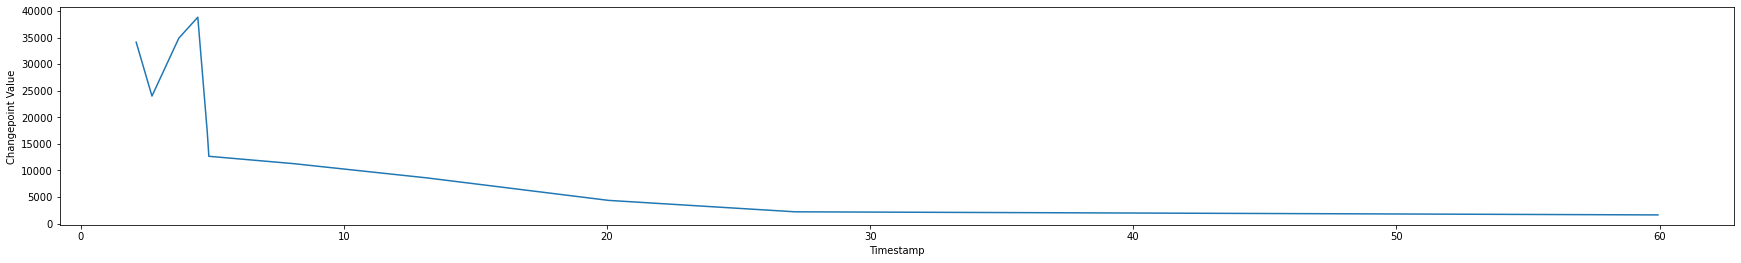

In [50]:
import seaborn as sns

x=excelOut[["Timestamp"]]
y=excelOut[["Changepoint Value"]]
sns.lineplot(data = excelOut, x = "Timestamp", y = "Changepoint Value")

In [51]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [52]:
signal.ts

0       0.00000
1       0.06006
2       0.12012
3       0.18018
4       0.24024
         ...   
995    59.75976
996    59.81982
997    59.87988
998    59.93994
999    60.00000
Name: ts, Length: 1000, dtype: float64

In [53]:
overlay

[26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 26294.631428571436,
 35314.65000000001,
 35314.65000000001,
 35314.65000000001,
 35314.65000000001,
 35314.65000000001,
 35314.65000000001,
 35314.65000000001,
 35314.65000000001,
 35314.65000000001,
 35314.65000000001,
 25783.99411764706,
 25783.99411764706,
 25783.99411764706,
 2578

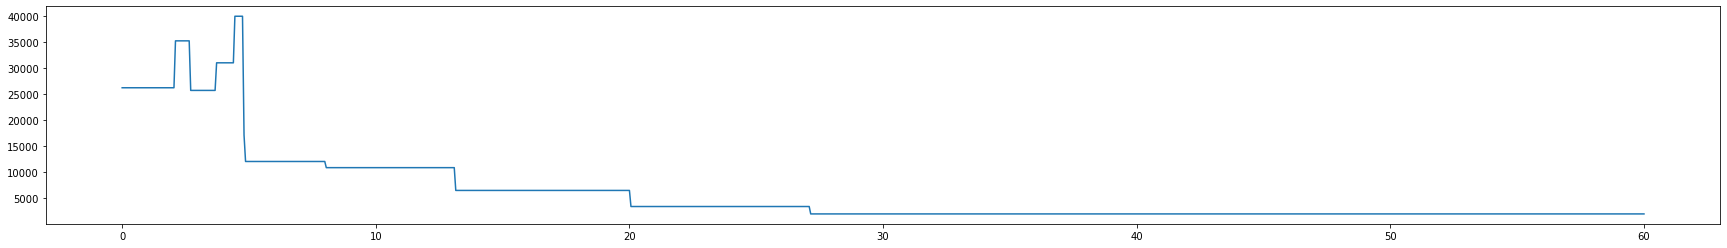

In [54]:
plt.plot(signal.ts, overlay)

In [55]:
excelSpread = pd.DataFrame({'signal':signal.ts, 'overlay':overlay})


In [56]:
excelSpread.to_csv("smoothData.csv")
